### Integrate atoti with Google SSO 

Note: Security features require [Atoti+ plugin](https://docs.atoti.io/latest/atoti_plus.html).  
This notebook is built based on the upcoming atoti v0.6.5. Refer to the latest documentation to see how you can [secure a session](https://docs.atoti.io/latest/how_tos/security/security.html).


In [1]:
import atoti as tt

In [2]:
session = tt.Session(
    port=9090,
    user_content_storage="./content",
    authentication=tt.OidcConfig(
        provider_id="google",
        # Below parameters are exposed for demo purpose.
        # Read connection details from environment variables for improved security.
        # See https://12factor.net/config.
        issuer_url="https://accounts.google.com",
        client_id="<Client Id>",
        client_secret="<Client Secret>",
        scopes=["https://www.googleapis.com/auth/userinfo.email"],
        name_claim="email",
    ),
)

In [3]:
# security is an Atoti+ feature that requires licensing
session.security.oidc.role_mapping.update({"atoti user": ["ROLE_USER", "ROLE_SHARE"]})

In [4]:
tt_telehealth = session.read_csv(
    "telehealth_dataset.csv",
    keys=["State", "Year", "Month", "TelehealthType", "ServiceType"],
    table_name="telehealth",
)
tt_telehealth.head()

,,,,,ServiceCount,RatePer1000Beneficiaries,DataQuality
TelehealthType,Month,Year,State,ServiceType,,,
Live audio/video,1,2018,Alabama,All,6905,5.6,N/A
Other telehealth,1,2018,Alabama,All,0,0.0,N/A
Remote patient monitoring,1,2018,Alabama,All,0,0.0,N/A
Store and forward,1,2018,Alabama,All,0,0.0,N/A
Live audio/video,1,2018,Alaska,All,907,4.3,N/A


In [5]:
cube = session.create_cube(tt_telehealth)

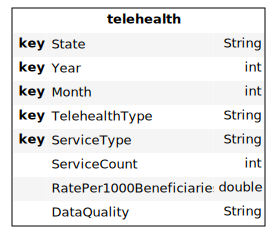

In [6]:
cube.schema

In [7]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [8]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Create multi-level hierarchy

In [9]:
h["Period"] = [l["Year"], l["Month"]]

### Create measures

In [10]:
# https://docs.atoti.io/latest/lib/atoti.html#atoti.parent_value
m["Parent total"] = tt.parent_value(m["ServiceCount.SUM"], degrees={h["Period"]: 1})

In [11]:
m["Percentage over parent"] = m["ServiceCount.SUM"] / m["Parent total"]

# https://docs.atoti.io/latest/tutorial/tutorial.html#Measure-formatters
m["Percentage over parent"].formatter = "DOUBLE[0.00%]"

In [12]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Querying output to dataframe  

Instead of visualization, we can query the cube into a Pandas DataFrame for manipulation or output to CSV.

In [13]:
# https://docs.atoti.io/latest/tutorial/tutorial.html#Multidimensional-concepts
cube.query(
    m["ServiceCount.SUM"],
    m["Percentage over parent"],
    levels=[l["telehealth", "Period", "Year"], l["telehealth", "Period", "Month"]],
    condition=l["telehealth", "Period", "Year"] == "2019",
)

ServiceCount.SUM Percentage over parent
Year Month                                        
2019 1              300,633                  7.78%
     2              281,380                  7.28%
     3              303,409                  7.85%
     4              327,052                  8.46%
     5              326,261                  8.44%
     6              284,689                  7.37%
     7              321,196                  8.31%
     8              338,250                  8.75%
     9              325,725                  8.43%
     10             379,070                  9.81%
     11             336,931                  8.72%
     12             340,285                  8.80%

In [14]:
df_atoti_query = cube.query(
    m["ServiceCount.SUM"],
    m["Percentage over parent"],
    levels=[l["telehealth", "Period", "Year"], l["telehealth", "Period", "Month"]],
    condition=l["telehealth", "Period", "Year"] == "2019",
).reset_index()

df_atoti_query.head()

,Year,Month,ServiceCount.SUM,Percentage over parent
0,2019,1,300633,0.077786
1,2019,2,281380,0.072804
2,2019,3,303409,0.078504
3,2019,4,327052,0.084622
4,2019,5,326261,0.084417


In [15]:
# output query to CSV programmatically - can be used to output batch reporting
# df_atoti_query.to_csv("atoti_query_output.csv", index=False)

### Web application 

In [16]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

#### Access saved/shared dashboard

In [18]:
session.link(path="/#/dashboard/2da")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### Incremental loading

Launched the above dashboard and watch the widget change as new data gets loaded into the cube.

In [ ]:
tt_telehealth.load_csv("realtime/telemetry-2020.csv")